In [ ]:
import matplotlib.pyplot as plt
import scipy.linalg as sl
import autograd.numpy.linalg as la
import autograd.numpy as np
import sys
import os
from datetime import datetime
from matplotlib.collections import LineCollection

## use the network you created using "Build a network" 

In [1]:
n_d = 93
NB = 316
netpath = '/Users/jiayiwu/experiment/bio/bio_network_2'
name = "/network_tri_num_p_%d_num_b_%d_fixed_" % (n_d, NB)
C = np.load(netpath + name + "Cde.npy")
points = np.load(netpath + name + "points.npy")
i_points = np.load(netpath + name + "i_points.npy")
connection = np.load(netpath + name + "Connection.npy")

# tri = Delaunay(points)
NB, dof = np.shape(C)
print("numbers of degree of freedom", dof)



186


## defining wanted soft mode structure

In [ ]:
nums = [3, 4, 88, 89]

v1 = np.zeros(dof)

v1[nums[0] * 2:nums[0] * 2 + 4] = [1, 0, -1, 0]
v1[nums[2] * 2:nums[2] * 2 + 4] = [-1, 0, 1, 0]

indT1 = np.where(v1 > 0)[0]
indF1 = np.where(v1 < 0)[0]
zos1 = [nums[0] * 2 + 1, nums[0] * 2 + 3, nums[2] * 2 + 1, nums[2] * 2 + 3]

v1 = v1 / la.norm(v1)

v2 = np.zeros(dof)

v2[nums[0] * 2:nums[0] * 2 + 4] = [1, 0, -1, 0]
v2[nums[2] * 2:nums[2] * 2 + 4] = [1, 0, -1, 0]

indT2 = np.where(v2 > 0)[0]
indF2 = np.where(v2 < 0)[0]

v2 = v2 / la.norm(v2)

In [2]:
def ENE(fev1, indT, indF, zos):
    return thes * 4 - lthes * 4 + sum(-np.minimum(fev1[indT], thes)) + sum(np.maximum(fev1[indF], -thes)) + sum(
        np.maximum(abs(fev1[zos]), lthes))


def E12(k, sv):
    D = D_from_k(k, C)  # get the dynamic matrix
    e1, ev1 = sl.eigh(D)  # np.linalg.eig(D)  # get the eigval and eigvect

    seq = np.argsort(e1)  # sort the eigval

    if sv == 'v1':
        indT = indT1
        indF = indF1
    if sv == 'v2':
        indT = indT2
        indF = indF2

    zos = zos1

    return min(ENE(ev1[:, seq[0]], indT, indF, zos), ENE(-ev1[:, seq[0]], indT, indF, zos))


def fdiff_grad_eigvec(k, indT, indF, zos, w2=1.):
    D = D_from_k(k, C)  # get the dynamic matrix
    e1, ev1 = sl.eigh(D)  # get the eigval and eigvect

    seq = np.argsort(e1)  # sort the eigval

    fvec1 = min(ENE(ev1[:, seq[0]], indT, indF, zos), ENE(-ev1[:, seq[0]], indT, indF, zos))
    n1, n2 = np.sort(e1)[:2]
    dis1 = -np.arctan((n2 - n1) / gamma)

    dk1 = np.zeros(len(k))
    dk2 = np.zeros(len(k))

    dk = np.zeros(len(k))
    eps = 0.00001

    for i in range(len(k)):
        ki = k.copy()
        ki[i] += eps
        D2 = D_from_k(ki, C)
        e2, ev2 = sl.eigh(D2)

        seq = np.argsort(e2)

        fvec2 = min(ENE(ev2[:, seq[0]], indT, indF, zos), ENE(-ev2[:, seq[0]], indT, indF,
                                                              zos))
        dk[i] = (fvec2 - fvec1) / eps

        n1i, n2i = np.sort(e2)[:2]

        dk1[i] = (n1i - n1) / eps
        dk2[i] = (n2i - n2) / eps

    grad = dk - w2 * (1. / (((n2 - n1) / gamma) ** 2 + 1) * (dk2 - dk1))  # + eta * np.exp(-(k0 +1) * eta) * dk1s)
    cons_ene = dis1  # - eta * np.exp(-eta * (k0+1))

    return grad, fvec1, cons_ene


def grad_des(run_time, eps, k, indT, indF, zos, w2=1):
    energy = np.zeros(run_time)

    precision = 10 ** (-10)
    cons_ene = np.zeros(run_time)
    E1 = []
    for i in range(run_time):

        grad1, ene, cons = fdiff_grad_eigvec(k, indT, indF, zos, w2)
        # grad2 = grad(auto_energy)(k)
        gradient = grad1  # +grad2
        # gradient[abs(gradient)<np.argmax(abs(gradient))] =0

        gradient[gradient > 10] = 0

        gradient[gradient == np.nan] = 0
        # aa = np.where(gradient == max(gradient))

        k = k - eps * gradient
        # k[aa] = 0
        k[k < 0] = 0

        energy[i] = ene
        cons_ene[i] = cons
        E1.append([E12(k, 'v1'), E12(k, 'v2')])

        if i > 1 and la.norm(gradient) < precision:
            print('converaged at step=%d with ene %0.2f ' % (i, energy[i]))
            return k, np.array([energy[:i], cons_ene[:i]]), E1

    return k, np.array([energy, cons_ene]), E1


def D_from_k(k, A):
    return A.T @ np.diag(k) @ A


def plot_eig(k, v, fv, sep_datapath, name, indT, indF, ylim=1):
    D = D_from_k(k, C)

    eigval, eigvect = sl.eigh(D)
    seq = np.argsort((eigval))
    print('eigval are', np.round(eigval[seq], 3))
    plt.figure(figsize=(10, 6))

    plt.subplot(121)
    plt.plot(v, 'c--', alpha=0.8, linewidth=2, label='target')
    plt.scatter(range(0, len(v)), v[:len(v)])

    if ENE(eigvect[:, seq[0]], indT, indF, zos1) < ENE(-eigvect[:, seq[0]], indT, indF, zos1):
        fvec1 = eigvect[:, seq[0]]
    else:
        fvec1 = -eigvect[:, seq[0]]

    plt.plot(fvec1, 'r--')
    plt.scatter(fv, fvec1[fv], color='r')
    plt.title(str(name)[-2:] + ' at cycle: ' + str(name)[:len(str(name)) - 2], fontsize=20)
    plt.ylim(-0.4, 0.4)

    eig = np.sort(eigval)

    ax1 = plt.subplot(133)
    aa = np.reshape(np.repeat(eig, 2), (-1, 2))
    # print(aa)
    for i in range(10):
        plt.plot(aa[i], label=str(np.round(eig[i], 2)))

    plt.ylim(min(eigval) - 0.1, ylim + min(eigval) - 0.1)
    x_axis = ax1.axes.get_xaxis()
    x_axis.set_visible(False)
    plt.legend(bbox_to_anchor=(-0.6, 1.), loc=2, borderaxespad=0.)

    plt.savefig(sep_datapath + '/' + str(name) + '.png')
    # plt.show()
    plt.close()


def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

def get_lines(xx,yy,NB=NB):
    xcon = []
    ycon = []
    for i in range(NB):

        if int(connection[i][0]) < len(xx):
            x0 = xx[int(connection[i][0])]
            y0 = yy[int(connection[i][0])]
        else:
            x0, y0 = points[int(connection[i][0])]
        if int(connection[i][1]) < len(xx):
            x1 = xx[int(connection[i][1])]
            y1 = yy[int(connection[i][1])]
        else:
            x1, y1 = points[int(connection[i][1])]

        xcon.append([x0, x1])
        ycon.append([y0, y1])

    xcon = np.array(xcon)
    ycon = np.array(ycon)
    return xcon, ycon

def plot_field(xx, yy,ip = i_points):
#     plt.scatter(xx, yy, color='r', alpha=1)
    for i in range(len(ip)):
        if i in nums:
            alp = 0.9
            c = 'blue'
            hw = 12

        else:
            c = 'black'
            alp = 0.3
            hw = 8

        plt.annotate("", xytext=(ip[:, 0][i], ip[:, 1][i]), xy=(xx[i], yy[i]),
                     arrowprops=dict(width=1.5, headwidth=hw, color=c, alpha=alp))

   
    
def plot_act_net(points, ip, k, dirp, name, indT, indF, v, amp=5):
    long = (int(max(points[:, 0]) - min(points[:, 0]) + 4)) % 20
    wid = (int(max(points[:, 1]) - min(points[:, 1]) + 4)) % 20
    print(long, wid)
    fig = plt.figure(figsize=(long, wid))

    plt.plot(points[:, 0], points[:, 1], 'o', color='black', alpha=0.2)
    plt.plot(ip[:, 0], ip[:, 1], 'o', color='black', alpha=0.2)
    D = D_from_k(k, C)

    eigval, eigvect = sl.eigh(D)
    seq = np.argsort((eigval))
    xs = range(0, dof, 2)
    ys = range(1, dof + 1, 2)

    if ENE(eigvect[:, seq[0]], indT, indF, zos1) > ENE(-eigvect[:, seq[0]], indT, indF, zos1):
        fev1 = -eigvect[:, seq[0]]
        xx = -amp * eigvect[:, seq[0]][xs] + ip[:, 0]
        yy = -amp * eigvect[:, seq[0]][ys] + ip[:, 1]
    else:
        fev1 = eigvect[:, seq[0]]
        xx = amp * eigvect[:, seq[0]][xs] + ip[:, 0]
        yy = amp * eigvect[:, seq[0]][ys] + ip[:, 1]
    
    plot_field(xx, yy)
    for i in np.concatenate((indT, indF)):

        xi = points[:, 0][int(i / 2)]
        yi = points[:, 1][int(i / 2)]
        if yi > 1:
            jj = 0.5
        else:
            jj = -0.5
        plt.annotate("", xy=(xi + v[i], yi + jj), xytext=(xi, yi + jj),
                     arrowprops=dict(width=1.5, color='black', alpha=0.8))

    
    plt.axes().set_aspect('equal', 'datalim')
    xcon,ycon = get_lines(xx,yy)

    elongation = C @ fev1
    lc = multiline(xcon, ycon, elongation, cmap='plasma', lw=2, alpha=0.7)
    axcb = fig.colorbar(lc)
    axcb.set_label('bond elongation ')

    plt.ylim(min(points[:, 1]) - 0.5, max(points[:, 1]) + 0.5)
    plt.xlim(min(points[:, 0]) - 0.5, max(points[:, 0]) + 0.5)
    plt.axis('off')
    plt.title(str(name)[-2:] + ' at: ' + str(name)[:len(str(name)) - 2] +
              'eigval = %0.2f with amplify :%d' % (eigval[seq[0]], amp), fontsize=20)
    plt.savefig(dirp + '/network_' + str(name) + '.pdf')
    print(eigval[seq][:5])
    plt.close()
    # plt.show()
    
    fig = plt.figure(figsize=(long, wid))
    plot_field(xx, yy)
    xcon,ycon = get_lines(ip[:,0],ip[:,1])
    lc = multiline(xcon, ycon, k, cmap='coolwarm', lw=2, alpha=1)
    axcb = fig.colorbar(lc)
    axcb.set_label('k')
    plt.axes().set_aspect('equal', 'datalim')

    plt.ylim(min(points[:, 1]) - 0.5, max(points[:, 1]) + 0.5)
    plt.xlim(min(points[:, 0]) - 0.5, max(points[:, 0]) + 0.5)
    plt.axis('off')
    plt.title(str(name)[-2:] + ' at: ' + str(name)[:len(str(name)) - 2] +
              ' eigval = %0.2f with amplify :%d' % (eigval[seq[0]], amp), fontsize=20)
    plt.savefig(dirp + '/k_network_' + str(name) + '.pdf')

    plt.close()

    # ake another one for k
    


def osc_goals(k, it, T, plotit=True, j=0):
    dif_ene = []
    dif_bond = []
    E1 = []
    plt.clf()
    plt.close()
    c_t_1 = []
    c_t_2 = []
    i = 0

    while i < T:

        k, energy1, E11 = grad_des(it, eps, k, indT2, indF2, zos1)
        plot_eig(k, v2, np.where(v2 != 0)[0], opath, '%02dv2' % i, indT2, indF2)
        plot_act_net(points, i_points, k, opath, '%02dv2' % i, indT2, indF2, v2)
        print(i)

        prev_k = k.copy()

        Ev2 = np.array(E11).T[1]
        E1 += E11

        if Ev2[-1] < precision:
            c_t_2 += [np.amin(np.where(Ev2 < precision)) / it]

        else:
            c_t_2 += [1]
        # print('end ene for v2 is', Ev2[-1])

        k, energy1, E11 = grad_des(it, eps, k, indT1, indF1, zos1)
        E1 += E11

        Ev1 = np.array(E11).T[0]
        # print('end ene for v1 is', Ev1[-1])

        if Ev1[-1] < precision:
            c_t_1 += [np.amin(np.where(Ev1 < precision)) / it]

        else:
            c_t_1 += [1]

        dif_ene += [la.norm(prev_k - k, 1)]
        diff = prev_k - k
        # print(diff)

        diff[abs(diff) < 0.5 * k] = 0

        dif_bond += [np.count_nonzero(diff)]
        plot_eig(k, v1, np.where(v1 != 0)[0], opath, '%02dv1' % i, indT1, indF1)
        plot_act_net(points, i_points, k, opath, '%02dv1' % i, indT1, indF1, v1)

        if c_t_1[-1] != 1 and c_t_2[-1] != 1:
            flag = True
            print('osc coveraged at', i)
            break
              

        i += 1

    if c_t_1[-1] == 1 or c_t_2[-1] == 1:

        flag = False
        print('osc didnt coverage')


        # return dif_bond, dif_ene, flag
    else:
        bondnum = np.where(abs(diff) > 0.5 * k)
        flag = True
        np.save(tpath + '/%02dv1_%d' % (j, T), prev_k)
        np.save(tpath + '/%02dv2_%d' % (j, T), k)
        np.save(tpath + '/%02d_bond_nums' % j, bondnum)

    if plotit:
        plt.clf()
        plt.close()
        plt.plot(c_t_1, label='v1 converage time')
        plt.plot(c_t_2, label='v2 converage time')
        plt.legend()
        # plt.xlim(0,20)
        plt.ylabel('converage time', fontsize=20)
        plt.xlabel('cycles', fontsize=20)
        plt.savefig(dirpath + '/T_%d_rt_%d_converage_time_%04d.png' % (T, it, j), dpi=100,
                    bbox_inches='tight')
        plt.close()
        # from mpl_toolkits.axes_grid.inset_locator import inset_axes

        fig = plt.figure(figsize=(7, 6))
        ax = fig.add_subplot(111)
        Ear = np.array(E1)

        # nn = 1  # np.max([int(it / 100), 1])

        ax.plot(np.arange(len(Ear.T[0])), Ear.T[0], label='G1')  # , s = 0.01)
        ax.plot(np.arange(len(Ear.T[1])), Ear.T[1], label='G2')
        # plt.plot(range(len(Ear.T[2])),Ear.T[2], label = 'E3 (Av3) changing over time')
        ax.set_ylabel('Energy changing over time')
        ax.set_xlabel('real time')
        fig.legend(bbox_to_anchor=(0.5, 0.55), loc=2, borderaxespad=0.)

        plt.ylim(ymin=0)

        plt.savefig(dirpath + '/T_%04d_rt_%d_Ene_A1_%04d.pdf' % (T, it, j), dpi=100)
        plt.close()
        # if flag:
        #    plot_eig(k, v1, np.where(v1 != 0)[0], tpath, '%02dv1' % j, indT1, indF1)
        #    plot_act_net(points, i_points, k, tpath, '%02dv1' % j, indT1, indF1, v1)

    #             plot_eig(prev_k, v2, np.where(v2 != 0)[0], tpath, '%02dv2' % j, indT2, indF2)
    #             plot_act_net(points, i_points, prev_k, tpath, '%02dv2' % j, indT2, indF2, v2)

    return dif_ene, dif_bond, flag

In [76]:
#Kall = np.load('/Users/jiayiwu/experiment/bio/bio_mec_s/ks_it_1000_500.npy')

## defining oscillating freq and saving folder 

In [3]:
T = 40
i = 2
dirpath = '/Users/jiayiwu/experiment/bio/bigsys_bio_mec_2019' + '/'
if not os.path.exists(dirpath): os.mkdir(dirpath)
opath = dirpath + '/plots%d_%d/'%(T,i)
if not os.path.exists(opath): os.mkdir(opath)
tpath = dirpath + '/switch_goal%d_%d/'%(T,i)
if not os.path.exists(tpath): os.mkdir(tpath)

### defining how much displacement at least in the direction (thes: direction of desired:at least 0.05 each node, 
### lthes: direction of undesired: less than 0.025 each node)
### gamma: making sure the second mode is larger than the soft mode
### run_time: training time

In [8]:
thes = 0.05
lthes = 0.025

gamma = 0.05  # making n2-n1 big
# eta = 0.5
precision = 0.05
eps = 0.1

run_time = 10000

it = int(run_time/T)
print(it)
# ori_k = np.random.rand(NB)#Kall[i]


250


## running oscillating goal experiment

In [2]:
# dif_ene_3, dif_bond, flag = osc_goals(ori_k, it, T, True, i)

## ploting functions

In [4]:
def plot_strain(points, ip, k, name, indT, indF, v, amp=5, alp= 1., cmap = 'Reds', color='k'):
    D = D_from_k(k, C)
    long = (int(max(points[:, 0]) - min(points[:, 0]) + 4)) % 20
    wid = (int(max(points[:, 1]) - min(points[:, 1]) + 4)) % 20
#     print(long, wid)
    fig = plt.figure(figsize=(long, wid))
 
    eigval, eigvect = sl.eigh(D)
    seq = np.argsort((eigval))
    
    xs = range(0, dof, 2)
    ys = range(1, dof + 1, 2)
    f_eig = eigvect[:, seq[0]]
    

    if ENE(f_eig, indT, indF, zos1) > ENE(-f_eig, indT, indF, zos1):
        fev1 = -f_eig
        xx = -amp * f_eig[xs] + ip[:, 0]
        yy = -amp * f_eig[ys] + ip[:, 1]
        
    else:
        fev1 = f_eig
        xx = amp * f_eig[xs] + ip[:, 0]
        yy = amp * f_eig[ys] + ip[:, 1]
    
    plot_field(xx, yy,ip = i_points)
    xcon, ycon = get_lines_1(points,ip)
    
    plt.axes().set_aspect('equal', 'datalim')

    if color=='elongation':
        elongation = abs(C @ fev1)
        lc = multiline(xcon, ycon, elongation, lw=2, alpha=alp, cmap = cmap)
        axcb = fig.colorbar(lc)
        axcb.set_label('delta x')
        plt.axis('off')
        return elongation
    else:
        elongation = abs(C @ fev1)
        lc = multiline(xcon, ycon, elongation, lw=3, alpha=alp, cmap = cmap)
        axcb = fig.colorbar(lc)
        axcb.set_label('delta x')
        plt.axis('off')
        lc2 = multiline(xcon, ycon, color, lw=10, alpha=0.2, cmap = 'Blues')

def get_lines_1(points,ip,NB=NB):
    xcon = []
    ycon = []
    for i in range(NB):

        if int(connection[i][0])< len(ip):
            x0 = ip[:, 0][int(connection[i][0])]#xx[int(connection[i][0])]
            y0 = ip[:, 1][int(connection[i][0])]#yy[int(connection[i][0])]
        else:
            x0, y0 = points[int(connection[i][0])]
        if int(connection[i][1])< len(ip):
            x1 = ip[:, 0][int(connection[i][1])]
            y1 = ip[:, 1][int(connection[i][1])]
        else:       
            x1, y1 = points[int(connection[i][1])]

        xcon.append([x0, x1])
        ycon.append([y0, y1])
    return xcon,ycon  


## making plots of the result

/Users/jiayiwu/anaconda/envs/bio/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/jiayiwu/anaconda/envs/bio/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


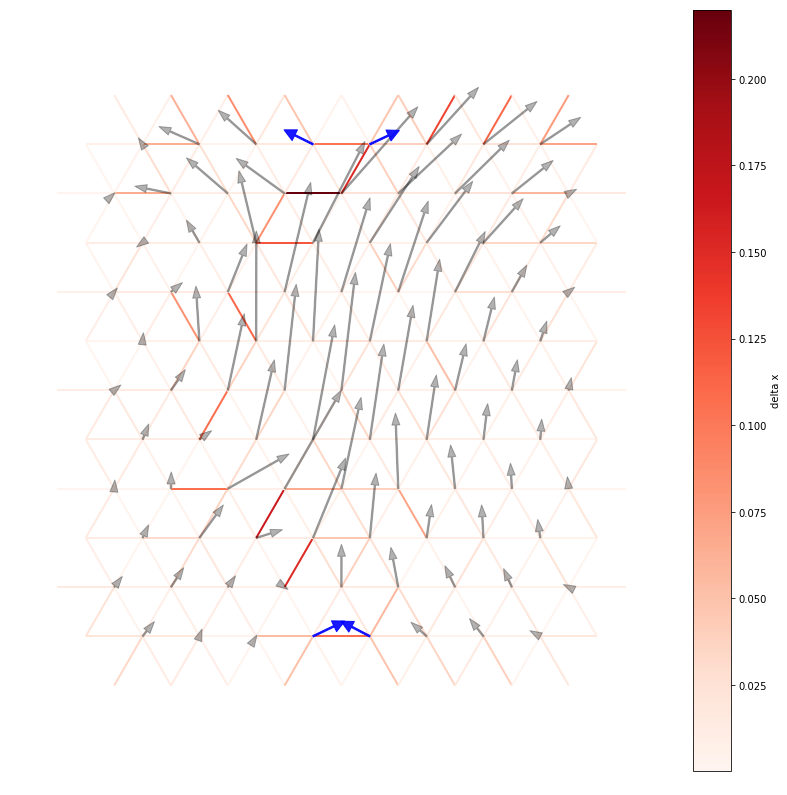

In [11]:
j = 0
new_k = k2w.copy()
plot_strain(points, i_points, new_k, name, indT1, indF1, v1, amp=10, color ='elongation')
changks = np.zeros(len(k2w))
plt.savefig('/Users/jiayiwu/experiment/bio/bigsys_bio_mec_2019/plot_changes/'+'%04d_k_init.pdf'%(j))
for i in seq[:15]:
    
    j+=1
    new_k[i] = k1w[i].copy()

    changks[i] = 10
    plot_strain(points, i_points, new_k, name, indT1, indF1, v1, amp=10, color =changks)
    plt.savefig('/Users/jiayiwu/experiment/bio/bigsys_bio_mec_2019/plot_changes/'+'%04d_k_%d.pdf'%(j,i))
    plt.close()
#     plt.show()
    

In [6]:
k1 = np.load('/Users/jiayiwu/experiment/bio/bigsys_bio_mec_2019/switch_goal20_2/02v1_20.npy')
k2 = np.load('/Users/jiayiwu/experiment/bio/bigsys_bio_mec_2019/switch_goal20_2/02v2_20.npy')
k1w = k1/np.mean(k1)
k2w = k2/np.mean(k2)

In [10]:
print(np.count_nonzero(abs(np.round(k2w-k1w,1))))

seq=np.argsort(abs(k2w-k1w))[::-1]
print(seq)

106
[ 25  56  23  24  20 101  57  22 107  30 132  79 110 106  49  55 181 184
   9  27 200  14  54 255 135   3 172 161  89  88  34 127 131  71  17  67
 186  43 279 236  87 302  53 116   0  51  90  18 163 224 206 226 284  63
  29 111 153 190 229  12 154 205  40 123 191 143 178  35  32  13 142 179
 141 267 275 306 119 260 158 300 130 100  59   5 171 312 194  52 150 223
 114 139  82 151  31  77  39 117 157  60 215 296 253 211 303  19 209   8
 274 268 125 299 234 298 218 105  74 145 239  96 269  26 144 202 104 270
 251 240  45 126 278  84 315 167 266 140 214 187 310 273   6  66 129  86
 103 283 314 170 231 225 177  44 220  99 216 201  94 247 173 195 175 259
 230 280 168   2 109 311 118 221  75  93 137 160 286 256  36 242 146  37
  42 156 203 232 152  10 307 244 193 263  48 248 198 120 290 294  98 138
 246  61 237   4 250 147 128 272 262 308  38  85 176  70  65  91 169 264
   1  21 265 292 235 313  50  28 112 196  16  41 212 282 199 192 285  58
 228   7  33 289  46 188 210  69 293  97  64 17

In [72]:
np.save(tpath + '/orik', ori_k)